In [2]:
# Readme
# This script uses segmented channel masks, luminal marker masks and basal marker masks extracted from imaris as tiffs.
# Make sure to label your files correctly by adding "_Duct", "_K14" and "_K818" to your filenames or replace by your respective markers
# The script analyses per file, so put all tiff files of one z stack in your input folder. It can not process several different files at once.
# In the end you will receive some plot showing luminal and basal coverage as well as the percentage of luminal_first coverage as well as the
# percentage of coverage with correct luminal_basal organization

In [1]:
# Import and load packages
from skimage import io
import os
import numpy as np
from scipy import ndimage
import math
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.ndimage import center_of_mass
from skimage.morphology import binary_erosion, disk
from scipy.optimize import least_squares
import gc
import IPython

# Ensure plots appear inline in the notebook
%matplotlib inline

In [2]:
# Define functions
# Function to delete all variables and plots from the workspace
def clear_workspace():
    plt.close('all')  # Close all open plots
    # Explicitly close all figures
    for i in plt.get_fignums():
        plt.figure(i).clf()
        plt.close(plt.figure(i))
    # Get the list of all variables in the global scope
    global_vars = list(globals().keys())
    # Do not delete the IPython built-in variables and the function itself
    protected_vars = ['clear_workspace', 'plt', 'gc', 'IPython']
    for var in global_vars:
        if var not in protected_vars:
            del globals()[var]
    gc.collect()  # Perform garbage collection to free up memory

# Define a function to calculate the distance between two points
def distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

#Calculate coverage of circumference points

def calculate_coverage_of_single_circumference_point(target_point, start_point, filtered_cell_stack_2D):
    px, py = target_point
    print("calculate_coverage_of_single_circumference_point" + str(target_point))
    cx, cy = start_point
    covered = False
    max_length = len(filtered_cell_stack_2D)
    while True:
        if px == cx and py == cy:
            break
        if cx == max_length or cx == -1 or cy == max_length or cy == -1:
            break
        if filtered_cell_stack_2D[cx, cy] == 1:
            covered = True
            break
        dx = abs(px - cx)
        dy = abs(py - cy)

        sx = 1 if px < cx else -1
        sy = 1 if py < cy else -1

        if dx > dy:
            cx -= sx
        else:
            cy -= sy
    return covered

#Signal sequence
def check_signal_sequence(target_point, start_point, basal_stack_2D, luminal_stack_2D, filtered_cell_stack_2D):
    px, py = target_point
    cx, cy = start_point
    covered = False
    luminal_first = False
    basal_first = False
    basal_found_after_luminal = False
    max_length = len(filtered_cell_stack_2D)
    while True:
        if px == cx and py == cy:
            break
        if cx == max_length or cx == -1 or cy == max_length or cy == -1:
            break
        if luminal_stack_2D[cx, cy] == 1 or basal_stack_2D[cx, cy] == 1:
            covered = True
            if not luminal_first and not basal_first and luminal_stack_2D[cx, cy] == 1:
                luminal_first = True
            elif not luminal_first and not basal_first and basal_stack_2D[cx, cy] == 1:
                basal_first = True
                break
            elif luminal_first and basal_stack_2D[cx, cy] == 1:
                basal_found_after_luminal = True
                break
        dx = abs(px - cx)
        dy = abs(py - cy)

        sx = 1 if px < cx else -1
        sy = 1 if py < cy else -1

        if dx > dy:
            cx -= sx
        else:
            cy -= sy 
    return luminal_first, basal_found_after_luminal, covered, basal_first

# Function to find outer edge points of the ring
def get_outer_edge_points(channel_slice, center=None, radius=None):
    # Erode the channel slice to isolate the outer edge
    eroded_slice = binary_erosion(channel_slice, disk(7))  # Further increase disk size
    outer_edge = channel_slice ^ eroded_slice  # XOR to get the outer edge

    contours = find_contours(outer_edge, 0.5)
    if len(contours) == 0:
        return []
    
    # Assuming the largest contour is the outer edge
    largest_contour = max(contours, key=len)

    if center is not None and radius is not None:
        # Filter points that are further from the center than a certain threshold
        largest_contour = [point for point in largest_contour if distance(point, center) > radius * 0.9]

    return largest_contour


# Function to fit a circle to the points
def fit_circle(points):
    def residuals(params, points):
        xc, yc, r = params
        return np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2) - r

    # Initial guess for circle center and radius
    x0 = np.mean(points[:, 0])
    y0 = np.mean(points[:, 1])
    r0 = np.mean(np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2))
    
    result = least_squares(residuals, x0=[x0, y0, r0], args=(points,))
    xc, yc, r = result.x
    return xc, yc, r

# Function to filter out inner edge points
def filter_inner_edge_points(edge_points, center, radius):
    filtered_points = []
    for point in edge_points:
        if distance(point, center) > radius:
            filtered_points.append(point)
    return filtered_points



In [8]:
# Define plotting function
def plot_and_save_slice_with_overlays(channel_slice, basal_slice, luminal_slice, cell_slice,  
                                        edge_points, coverage_points, center, output_path, slice_index, 
                                        luminal_first_points, basal_after_luminal_points, 
                                        percentage_luminal_first_image, percentage_basal_after_luminal_image, basal_first_points):
    
    # Find bounding box of the region with signal in channel_slice
    rows = np.any(channel_slice, axis=1)
    cols = np.any(channel_slice, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    channel_slice = channel_slice[rmin:rmax+1, cmin:cmax+1]
    basal_slice = basal_slice[rmin:rmax+1, cmin:cmax+1]
    luminal_slice = luminal_slice[rmin:rmax+1, cmin:cmax+1]
    cell_slice = cell_slice[rmin:rmax+1, cmin:cmax+1]
    
    # Adjust the points according to the crop
    cropped_edge_points = [(int(x - rmin), int(y - cmin)) for x, y in edge_points]
    cropped_center = (int(center[0] - rmin), int(center[1] - cmin))
    
    # Create figure and subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    
    # Set facecolor for figure and subplots
    fig.patch.set_facecolor('white')
    for ax in axs.flatten():
        ax.set_facecolor('white')
        ax.tick_params(axis='both', which='both', length=0)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # First subplot: Channel mask (black) + center point (magenta)
    axs[0, 0].imshow(channel_slice, cmap='gray_r')
    axs[0, 0].set_title("Channel Mask", color='gray')
    axs[0, 0].plot(cropped_center[1], cropped_center[0], 'o', color='magenta', markersize=8)  # Center of mass
    axs[0, 0].axis('off')

    # Second subplot: Cell mask (invert colors: zeros gray, ones red)
    cell_color_overlay_basal = np.ones((*cell_slice.shape, 3), dtype=np.uint8) * 255  # Initialize with white
    cell_color_overlay_basal[basal_slice > 0] = [143, 79, 80]  # Dark red for basal cells
    cell_color_overlay_luminal = np.ones((*cell_slice.shape, 3), dtype=np.uint8) * 255  # Initialize with white
    cell_color_overlay_luminal[luminal_slice > 0] = [225, 194, 194]  # Light red for luminal cells
    axs[0, 1].imshow(np.ones_like(basal_slice), cmap='gray')  # White background
    axs[0, 1].imshow(cell_color_overlay_basal, alpha=0.5)
    axs[0, 1].imshow(cell_color_overlay_luminal, alpha=0.5)
    axs[0, 1].set_title("Cells (basal = dark red; luminal = light red)", color='black')
    axs[0, 1].plot(cropped_center[1], cropped_center[0], 'o', color='magenta', markersize=8)  # Center of mass
    axs[0, 1].axis('off')

    # Third subplot: Channel mask + Cell mask + Target points (yellow = luminal first; cyan = basal first; red = not covered)

    luminal_first_text = f"{percentage_luminal_first_image:.2f}%"

    #--------------
    axs[1, 0].imshow(channel_slice, cmap='gray_r')
    axs[1, 0].imshow(cell_color_overlay_luminal, alpha=0.75)
    axs[1, 0].imshow(cell_color_overlay_basal, alpha=0.75)
    
    for point, luminal_first, basal_first in zip(cropped_edge_points, luminal_first_points, basal_first_points):
        color = 'yellow' if luminal_first else 'cyan' if basal_first else 'red'
        axs[1, 0].plot(point[1], point[0], 'o', color=color, markersize=2)
    
    # Add percentage covered text slightly lower than the center
    axs[1, 0].text(channel_slice.shape[1] // 2, channel_slice.shape[0] // 2 + 30, luminal_first_text, color='black', fontsize=16, fontweight='bold', ha='center', va='center')
    
    axs[1, 0].set_title("Channel Mask + Cells + Target points (yellow = luminal first; cyan = basal first; red = not covered)", color='black')
    axs[1, 0].plot(cropped_center[1], cropped_center[0], 'o', color='magenta', markersize=8)  # Center of mass

    axs[1, 0].axis('off')


    # Subplot 4: Channel mask + cells + target points (yellow = basal after luminal (correct organization):
    # cyan = luminal first but not covered by basal; green = basal first red = not covered)
    axs[1, 1].imshow(channel_slice, cmap='gray_r')
    axs[1, 1].imshow(cell_color_overlay_luminal, alpha=0.75)
    axs[1, 1].imshow(cell_color_overlay_basal, alpha=0.75)
    
    for point, basal_first, basal_after_luminal, luminal_first in zip(cropped_edge_points, basal_first_points, basal_after_luminal_points, luminal_first_points):
        color = 'yellow' if basal_after_luminal else 'cyan' if luminal_first and not basal_after_luminal else 'green' if basal_first else 'red'
        axs[1, 1].plot(point[1], point[0], 'o', color=color, markersize=5)
    basal_after_luminal_text = f"{percentage_basal_after_luminal_image:.2f}%"
    # Add percentage covered text slightly lower than the center
    axs[1, 1].text(channel_slice.shape[1] // 2, channel_slice.shape[0] // 2 + 30, basal_after_luminal_text , color='black', fontsize=16, fontweight='bold', ha='center', va='center')
    
    axs[1, 1].set_title("Channel Mask + Cells + target points \n (yellow = basal after luminal (correct organization); cyan = luminal first but not covered by basal; \n green = basal first red = not covered)", color='black')
    axs[1, 1].plot(cropped_center[1], cropped_center[0], 'o', color='magenta', markersize=8)  # Center of mass

    axs[1, 1].axis('off')

    plt.tight_layout()
    
    # Display the figure with a white background
    plt.show()
    
    # Save the figure with a white background
    output_filename = f'slice_{slice_index:03d}.png'
    output_filepath = os.path.join(output_path, output_filename)
    fig.savefig(output_filepath, facecolor='white')
    plt.close(fig)
    

In [4]:
# Load all TIFF files in the folder
# Prompt the user for the folder path
folder_path = input("Please enter the folder path containing the TIFF files: ")
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]
print("Done loading")

Done loading


In [5]:
# Make channel, luminal and basal stacks
# Sort the file list to ensure consistent ordering
file_list.sort()

# Separate channel and cell mask files
# Separate channel and cell mask files
channel_files = [file for file in file_list if "_Duct.tif" in file]
basal_files = [file for file in file_list if "_K14.tif" in file]
luminal_files = [file for file in file_list if "_K818.tif" in file]

# Read the first TIFF file to get dimensions
first_tiff = io.imread(channel_files[0])
num_slices = len(channel_files)

# Create empty arrays to store binary masks
channel_stack = np.zeros((first_tiff.shape[0], first_tiff.shape[1], num_slices), dtype=bool)
basal_stack = np.zeros((first_tiff.shape[0], first_tiff.shape[1], num_slices), dtype=bool)
luminal_stack = np.zeros((first_tiff.shape[0], first_tiff.shape[1], num_slices), dtype=bool)

# Read channel and cell mask TIFF files and stack them
print("Start stacking")
for i in range(num_slices):
    channel_stack[:, :, i] = io.imread(channel_files[i])
    basal_stack[:, :, i] = io.imread(basal_files[i])
    luminal_stack[:, :, i] = io.imread(luminal_files[i])
print("Done stacking")

Start stacking
Done stacking


In [6]:
# Make sure all stacks have the right size
# Define the cutoff slice (last good slice) due to diminishing intensity with z depth
cutoff_slice_index = 50  # change as per your observation
# Crop the gel stack to only include up to the cutoff slice
channel_stack = channel_stack[..., :cutoff_slice_index+1]
basal_stack = basal_stack[..., :cutoff_slice_index+1]
luminal_stack = luminal_stack[..., :cutoff_slice_index+1]


num_slices = cutoff_slice_index
# Get the current shape of the arrays
current_shape = channel_stack.shape

# Determine the target size (max of rows and columns)
target_size = max(current_shape[0], current_shape[1])

# Calculate the number of rows and columns to add
num_rows_to_add = target_size - current_shape[0]
num_cols_to_add = target_size - current_shape[1]

# Create arrays of zeros to add for rows and columns
if num_rows_to_add > 0:
    zeros_to_add_rows = np.zeros((num_rows_to_add, current_shape[1], current_shape[2]), dtype=channel_stack.dtype)
    channel_stack = np.concatenate((channel_stack, zeros_to_add_rows), axis=0)
    basal_stack = np.concatenate((basal_stack, zeros_to_add_rows), axis=0)
    luminal_stack = np.concatenate((luminal_stack, zeros_to_add_rows), axis=0)

if num_cols_to_add > 0:
    zeros_to_add_cols = np.zeros((channel_stack.shape[0], num_cols_to_add, current_shape[2]), dtype=channel_stack.dtype)
    channel_stack = np.concatenate((channel_stack, zeros_to_add_cols), axis=1)
    basal_stack = np.concatenate((basal_stack, zeros_to_add_cols), axis=1)
    luminal_stack = np.concatenate((luminal_stack, zeros_to_add_cols), axis=1)

calculate_coverage_of_single_circumference_point(1012, 1207)
calculate_coverage_of_single_circumference_point(1012, 1206)
calculate_coverage_of_single_circumference_point(1012, 1205)
calculate_coverage_of_single_circumference_point(1012, 1204)
calculate_coverage_of_single_circumference_point(1012, 1203)
calculate_coverage_of_single_circumference_point(1012, 1202)
calculate_coverage_of_single_circumference_point(1012, 1201)
calculate_coverage_of_single_circumference_point(1012, 1200)
calculate_coverage_of_single_circumference_point(1012, 1199)
calculate_coverage_of_single_circumference_point(1012, 1198)
calculate_coverage_of_single_circumference_point(1012, 1197)
calculate_coverage_of_single_circumference_point(1012, 1196)
calculate_coverage_of_single_circumference_point(1012, 1195)
calculate_coverage_of_single_circumference_point(1012, 1194)
calculate_coverage_of_single_circumference_point(1012, 1193)
calculate_coverage_of_single_circumference_point(1012, 1192)
calculate_coverage_of_si

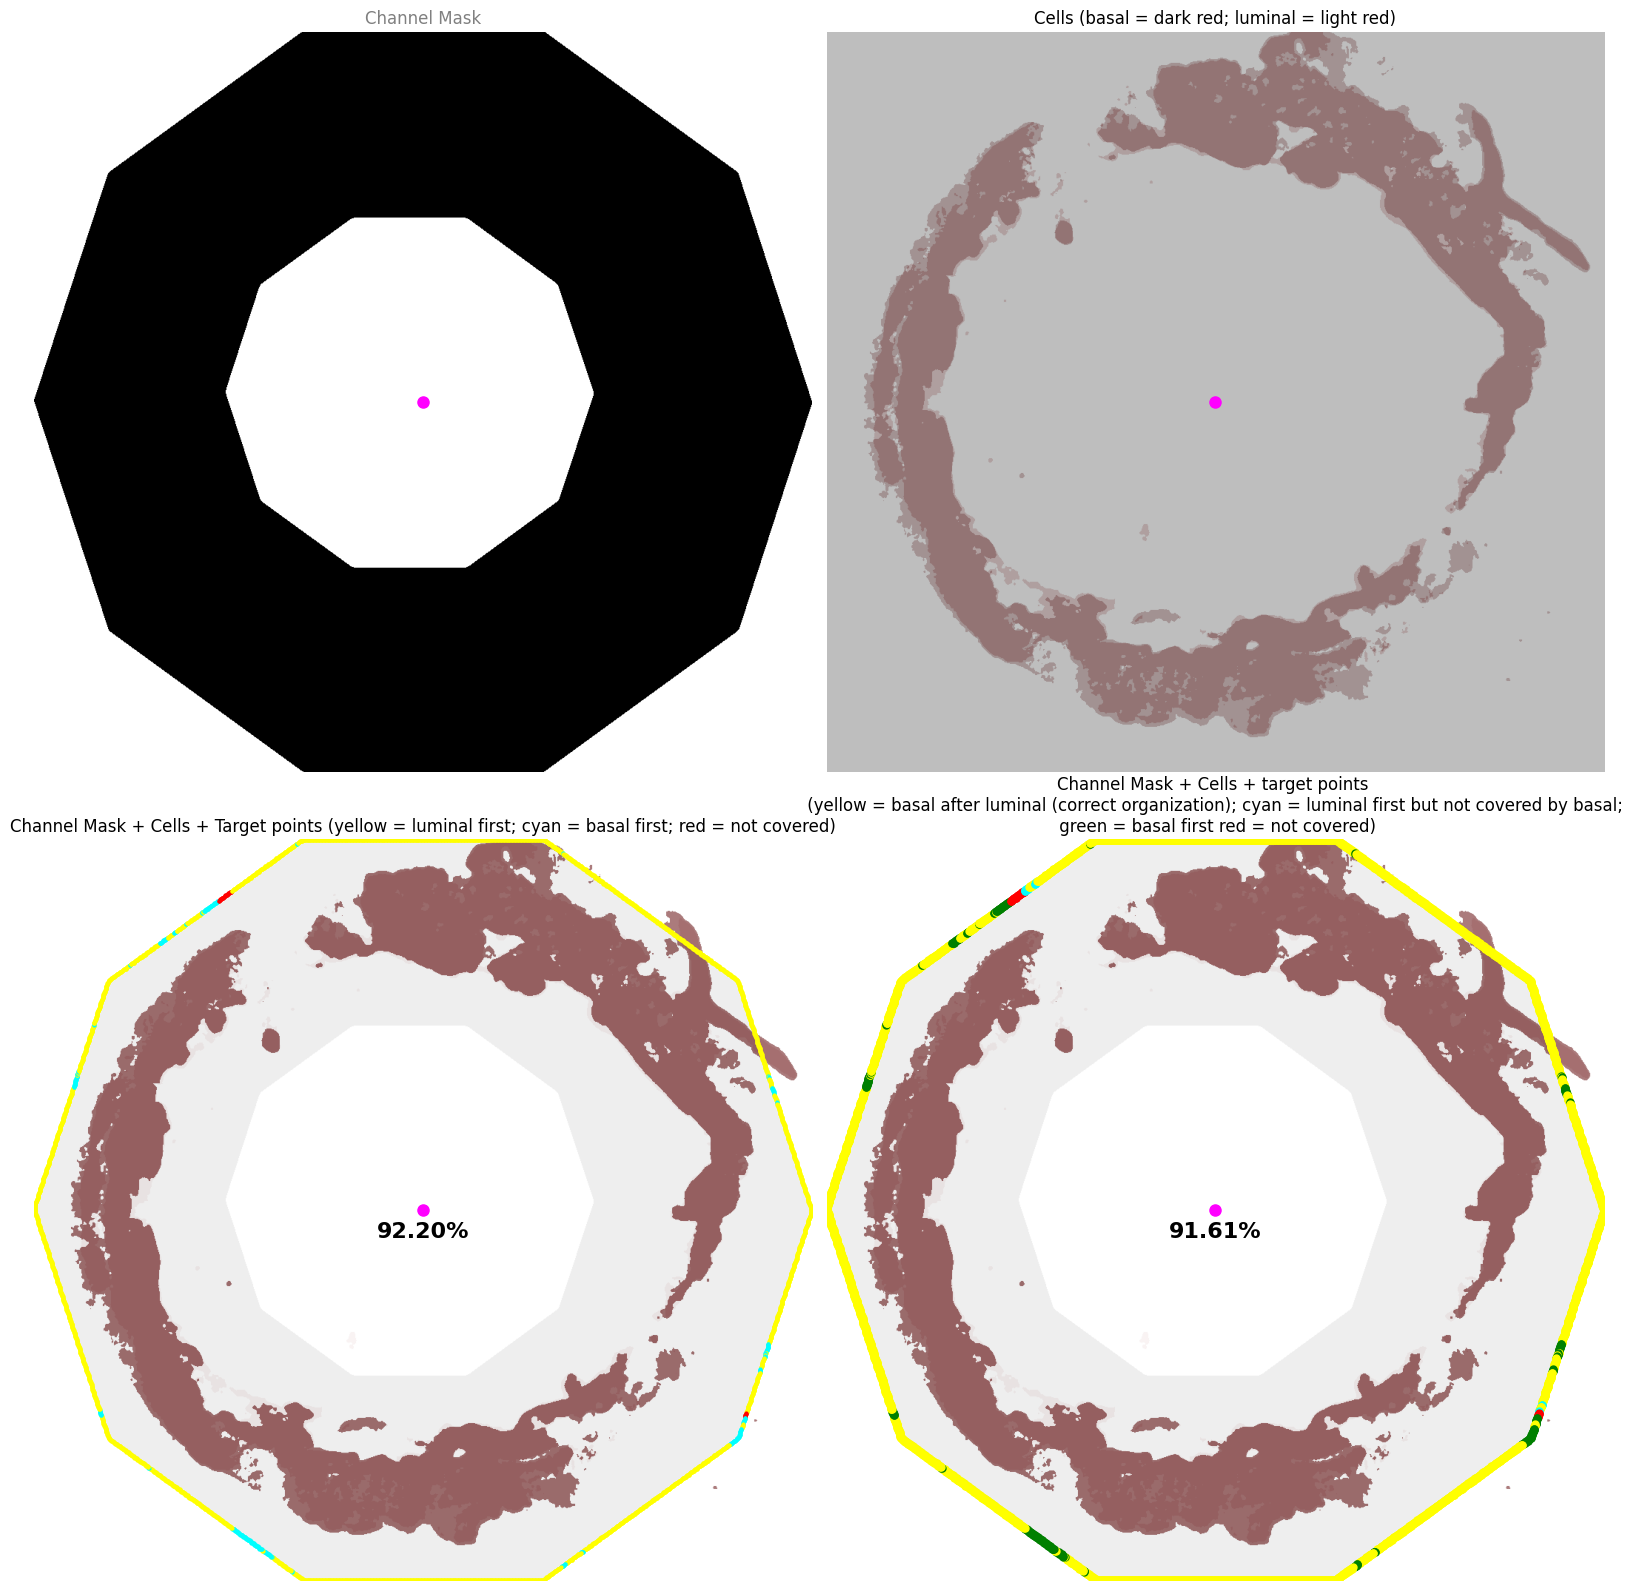

calculate_coverage_of_single_circumference_point(1013, 1208)
calculate_coverage_of_single_circumference_point(1013, 1207)
calculate_coverage_of_single_circumference_point(1013, 1206)
calculate_coverage_of_single_circumference_point(1013, 1205)
calculate_coverage_of_single_circumference_point(1013, 1204)
calculate_coverage_of_single_circumference_point(1013, 1203)
calculate_coverage_of_single_circumference_point(1013, 1202)
calculate_coverage_of_single_circumference_point(1013, 1201)
calculate_coverage_of_single_circumference_point(1013, 1200)
calculate_coverage_of_single_circumference_point(1013, 1199)
calculate_coverage_of_single_circumference_point(1013, 1198)
calculate_coverage_of_single_circumference_point(1013, 1197)
calculate_coverage_of_single_circumference_point(1013, 1196)
calculate_coverage_of_single_circumference_point(1013, 1195)
calculate_coverage_of_single_circumference_point(1013, 1194)
calculate_coverage_of_single_circumference_point(1013, 1193)
calculate_coverage_of_si

KeyboardInterrupt: 

In [9]:
# Calculate percentages luminal first and correct organization and plot every 25 slices
# Initialize variables
percentage_covered = 0
percentage_luminal_first = 0
percentage_basal_after_luminal = 0
num_slices_used = 0
output_path = folder_path  # Update this to your desired output folder path
cell_stack = basal_stack + luminal_stack

# Main loop to process each slice
for i in range(num_slices):
    if not np.any(channel_stack[:, :, i]):
        continue  # Skip if channel_stack slice is all zeros
    
    num_slices_used += 1
    filtered_cell_stack = channel_stack[:, :, i] * cell_stack[:, :, i]
    basal_slice = basal_stack[:,:,i]
    luminal_slice = luminal_stack[:,:,i]
    
    # Get the initial outer edge points of the ring
    initial_edge_points = get_outer_edge_points(channel_stack[:, :, i])
    if len(initial_edge_points) == 0:
        continue  # Skip if no edge points found
    
    # Convert initial edge points to numpy array for circle fitting
    edge_points_array = np.array(initial_edge_points)
    
    # Fit a circle to the outer edge points to extrapolate the center of mass
    xc, yc, r = fit_circle(edge_points_array)
    center = np.array([xc, yc], dtype=int)
    
    # Get the filtered outer edge points based on the center and radius
    edge_points = get_outer_edge_points(channel_stack[:, :, i], center, r)
    
    counter_covered = 0
    counter_luminal_first = 0
    counter_basal_after_luminal = 0
    counter_basal_first = 0
    coverage_points = []
    luminal_first_points = []
    basal_after_luminal_points = []
    basal_first_points = []

    
    for point in edge_points:
        point = tuple(map(int, point))  # Ensure the point is in integer format
        covered = calculate_coverage_of_single_circumference_point(point, center, filtered_cell_stack)
        luminal_first, basal_found_after_luminal, covered, basal_first = check_signal_sequence(point, center, basal_slice, luminal_slice, filtered_cell_stack)
        coverage_points.append(covered)
        luminal_first_points.append(luminal_first)
        basal_after_luminal_points.append(basal_found_after_luminal)
        basal_first_points.append(basal_first)
        if covered:
            counter_covered += 1
            if luminal_first:
                counter_luminal_first += 1
            else:
                counter_basal_first += 1
            if basal_found_after_luminal:
                counter_basal_after_luminal += 1


    # Calculate percentage over slices
    percentage_covered_image = counter_covered / len(edge_points) * 100
    percentage_covered += percentage_covered_image

    percentage_luminal_first_image = counter_luminal_first / counter_covered * 100
    percentage_luminal_first += percentage_luminal_first_image

    percentage_basal_after_luminal_image = counter_basal_after_luminal / counter_covered * 100
    percentage_basal_after_luminal += percentage_basal_after_luminal_image
    
    # Output of percentages per Slice
    print(f"Percentage Cell Coverage on the ring: {percentage_covered_image:.2f}%, for image Nr: {i}")
    print(f"Percentage Luminal first on the ring: {percentage_luminal_first_image:.2f}%, for image Nr: {i}")
    print(f"Percentage Basal after Luminal on the ring: {percentage_basal_after_luminal_image:.2f}%, for image Nr: {i}")


    
    # Plot and save the current slice with overlays every 25 slices
    if i % 25 == 0:
        plot_and_save_slice_with_overlays(channel_stack[:, :, i], basal_stack[:,:,i], luminal_stack[:,:,i], cell_stack[:, :, i], edge_points, coverage_points, center, output_path, i, luminal_first_points, basal_after_luminal_points, percentage_luminal_first_image, percentage_basal_after_luminal_image, basal_first_points)

# Calculate average percentage covered over all slices
average_percentage_covered = percentage_covered / num_slices_used
average_percentage_luminal_first = percentage_luminal_first / num_slices_used
average_percentage_basal_after_luminal = percentage_basal_after_luminal / num_slices_used

# Print Results of average over File
print(f"Average Percentage Cell Coverage on the ring over all slices: {average_percentage_covered:.2f}%")
print(f"Average Percentage Luminal first on the ring over all slices: {average_percentage_luminal_first:.2f}%")
print(f"Average Percentage Basal after Luminal on the ring over all slices: {average_percentage_basal_after_luminal:.2f}%")







In [10]:
# Prompt the user
response = input("Delete values and graphs from workspace? (yes/no): ").strip().lower()

if response == "yes":
    clear_workspace()
    IPython.get_ipython().magic('reset -sf')  # Reset the IPython environment
    print("Workspace cleared.")
else:
    print("Workspace not cleared. Script ended.")

Workspace cleared.
